# spark-bestfit Discrete Distribution Demo

This notebook demonstrates fitting **discrete (count) distributions** using the `DiscreteDistributionFitter` class.

Use cases:
- Event counts (website visits, error occurrences, purchases)
- Count data (items per order, failures per unit, defects per batch)
- Any integer-valued data

Key differences from continuous fitting:
- Uses PMF (probability mass function) instead of PDF
- Fits via MLE optimization (scipy discrete dists don't have built-in `fit()`)
- Integer-aligned histograms
- **AIC recommended** for model selection (K-S p-values are not reliable for discrete data)

## Setup

In [1]:
import numpy as np
from pyspark.sql import SparkSession

# Create Spark session
spark = (
    SparkSession.builder
    .appName("Discrete-Distribution-Demo")
    .config("spark.sql.shuffle.partitions", "10")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print(f"Spark version: {spark.version}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/12/25 23:17:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


25/12/25 23:17:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark version: 4.1.0


In [2]:
# Import discrete fitting components
from spark_bestfit import (
    DiscreteDistributionFitter,
    DiscreteDistributionRegistry,
    DEFAULT_EXCLUDED_DISCRETE_DISTRIBUTIONS,
)

## Generate Sample Data

We'll create sample data from known discrete distributions.

In [3]:
np.random.seed(42)

# Poisson data (event counts, e.g., website visits per hour)
poisson_data = np.random.poisson(lam=7.5, size=10_000)
df_poisson = spark.createDataFrame([(int(x),) for x in poisson_data], ["counts"])

# Negative binomial data (overdispersed counts, e.g., insurance claims)
nbinom_data = np.random.negative_binomial(n=5, p=0.4, size=10_000)
df_nbinom = spark.createDataFrame([(int(x),) for x in nbinom_data], ["counts"])

# Geometric data (trials until success, e.g., attempts until conversion)
geom_data = np.random.geometric(p=0.25, size=10_000)
df_geom = spark.createDataFrame([(int(x),) for x in geom_data], ["counts"])

print(f"Poisson(λ=7.5): {len(poisson_data):,} samples, mean={poisson_data.mean():.2f}")
print(f"NegBinom(n=5, p=0.4): {len(nbinom_data):,} samples, mean={nbinom_data.mean():.2f}")
print(f"Geometric(p=0.25): {len(geom_data):,} samples, mean={geom_data.mean():.2f}")

Poisson(λ=7.5): 10,000 samples, mean=7.52
NegBinom(n=5, p=0.4): 10,000 samples, mean=7.44
Geometric(p=0.25): 10,000 samples, mean=3.99


---

# Part 1: Available Discrete Distributions

In [4]:
# View available discrete distributions
registry = DiscreteDistributionRegistry()
distributions = registry.get_distributions()

print(f"Available discrete distributions ({len(distributions)}):")
for dist in sorted(distributions):
    config = registry.get_param_config(dist)
    print(f"  {dist:15} params: {config['param_names']}")

Available discrete distributions (16):
  betabinom       params: ['n', 'a', 'b']
  betanbinom      params: ['n', 'a', 'b']
  binom           params: ['n', 'p']
  boltzmann       params: ['lambda', 'N']
  dlaplace        params: ['a']
  geom            params: ['p']
  hypergeom       params: ['M', 'n', 'N']
  logser          params: ['p']
  nbinom          params: ['n', 'p']
  nhypergeom      params: ['M', 'n', 'r']
  planck          params: ['lambda']
  poisson         params: ['mu']
  skellam         params: ['mu1', 'mu2']
  yulesimon       params: ['alpha']
  zipf            params: ['a']
  zipfian         params: ['a', 'n']


In [5]:
# Default excluded distributions (slow or problematic)
print(f"\nDefault excluded ({len(DEFAULT_EXCLUDED_DISCRETE_DISTRIBUTIONS)}):")
for dist in sorted(DEFAULT_EXCLUDED_DISCRETE_DISTRIBUTIONS):
    print(f"  - {dist}")


Default excluded (5):
  - bernoulli
  - nchypergeom_fisher
  - nchypergeom_wallenius
  - poisson_binom
  - randint


---

# Part 2: Fitting Discrete Distributions

In [6]:
# Create discrete fitter
fitter = DiscreteDistributionFitter(spark)

# Fit distributions to Poisson data
print("Fitting discrete distributions to Poisson data...")
results_poisson = fitter.fit(df_poisson, column="counts")

print(f"\nFitted {results_poisson.count()} distributions")

Fitting discrete distributions to Poisson data...



Fitted 10 distributions


In [7]:
# Get best distributions by AIC (recommended for discrete)
print("Top 5 distributions by AIC (lower is better):")
for i, r in enumerate(results_poisson.best(n=5, metric="aic"), 1):
    params_str = ", ".join([f"{p:.3f}" for p in r.parameters])
    print(f"  {i}. {r.distribution:15} AIC={r.aic:.2f} params=({params_str})")

Top 5 distributions by AIC (lower is better):
  1. poisson         AIC=48318.28 params=(7.519)
  2. skellam         AIC=48320.21 params=(7.530, 0.011)
  3. nbinom          AIC=48321.48 params=(565.354, 0.987)
  4. betabinom       AIC=48332.90 params=(26.000, 17.796, 43.739)
  5. binom           AIC=48999.64 params=(26.000, 0.289)


In [8]:
# Best fit should be Poisson with λ ≈ 7.5
best = results_poisson.best(n=1, metric="aic")[0]
print(f"\nBest fit: {best.distribution}")
print(f"  Parameters: {[f'{p:.4f}' for p in best.parameters]}")
print(f"  AIC: {best.aic:.2f}")
print(f"  BIC: {best.bic:.2f}")
print(f"  SSE: {best.sse:.6f}")
print(f"  K-S statistic: {best.ks_statistic:.6f} (for ranking only)")
print(f"  A-D statistic: {best.ad_statistic}" )  # None for discrete distributions


Best fit: poisson
  Parameters: ['7.5190']
  AIC: 48318.28
  BIC: 48325.49
  SSE: 0.000087
  K-S statistic: 0.147657 (for ranking only)
  A-D statistic: None


---

# Part 3: Plotting Discrete Distributions

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

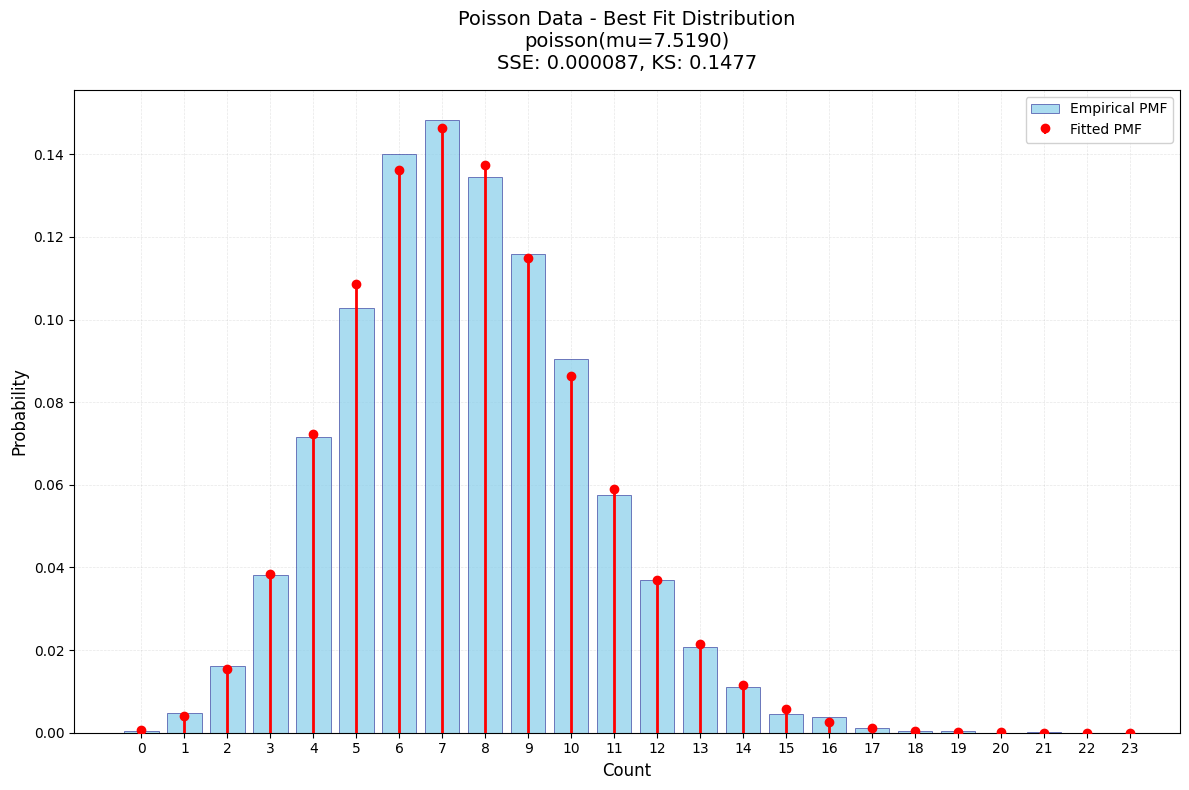

In [10]:
# Plot best fit for Poisson data
fig, ax = fitter.plot(
    best,
    df_poisson,
    "counts",
    title="Poisson Data - Best Fit Distribution",
    xlabel="Count",
    ylabel="Probability",
    figsize=(12, 8),
)
plt.show()

---

# Part 4: Negative Binomial Data (Overdispersion)

In [11]:
# Fit distributions to negative binomial data
print("Fitting distributions to negative binomial data...")
results_nbinom = fitter.fit(df_nbinom, column="counts")

print("\nTop 5 distributions by AIC:")
for i, r in enumerate(results_nbinom.best(n=5, metric="aic"), 1):
    params_str = ", ".join([f"{p:.3f}" for p in r.parameters])
    print(f"  {i}. {r.distribution:15} AIC={r.aic:.2f} params=({params_str})")

Fitting distributions to negative binomial data...



Top 5 distributions by AIC:
  1. nbinom          AIC=56051.79 params=(4.951, 0.400)
  2. betabinom       AIC=56104.36 params=(39.000, 3.445, 14.595)
  3. skellam         AIC=57262.30 params=(12.234, 4.795)
  4. planck          AIC=61425.01 params=(0.126)
  5. poisson         AIC=61571.19 params=(7.439)


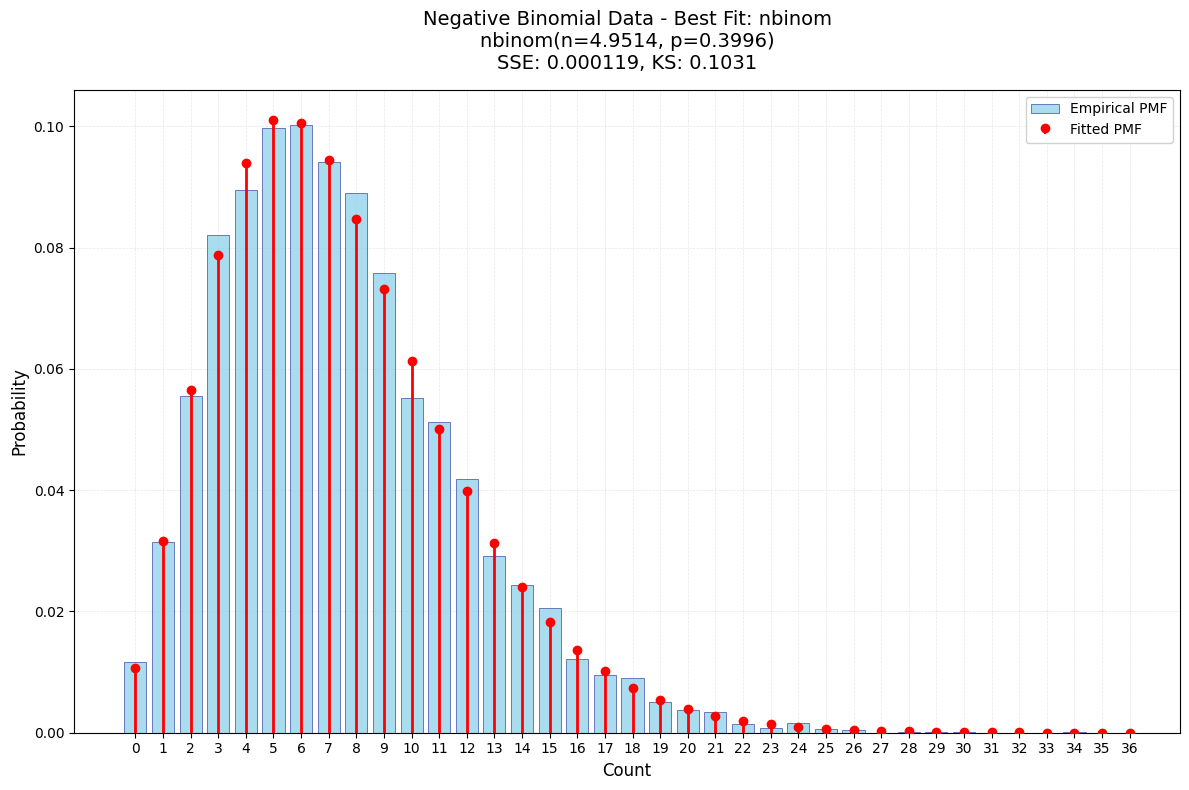

In [12]:
# Plot negative binomial fit
best_nbinom = results_nbinom.best(n=1, metric="aic")[0]

fig, ax = fitter.plot(
    best_nbinom,
    df_nbinom,
    "counts",
    title=f"Negative Binomial Data - Best Fit: {best_nbinom.distribution}",
    xlabel="Count",
    ylabel="Probability",
    figsize=(12, 8),
)
plt.show()

---

# Part 5: Geometric Data (Trials Until Success)

In [13]:
# Fit distributions to geometric data
print("Fitting distributions to geometric data...")
results_geom = fitter.fit(df_geom, column="counts")

print("\nTop 5 distributions by AIC:")
for i, r in enumerate(results_geom.best(n=5, metric="aic"), 1):
    params_str = ", ".join([f"{p:.3f}" for p in r.parameters])
    print(f"  {i}. {r.distribution:15} AIC={r.aic:.2f} params=({params_str})")

Fitting distributions to geometric data...



Top 5 distributions by AIC:
  1. geom            AIC=44924.27 params=(0.251)
  2. logser          AIC=46440.37 params=(0.903)
  3. nbinom          AIC=47643.77 params=(2.793, 0.412)
  4. betabinom       AIC=47954.61 params=(44.000, 2.306, 22.979)
  5. yulesimon       AIC=49541.18 params=(0.829)


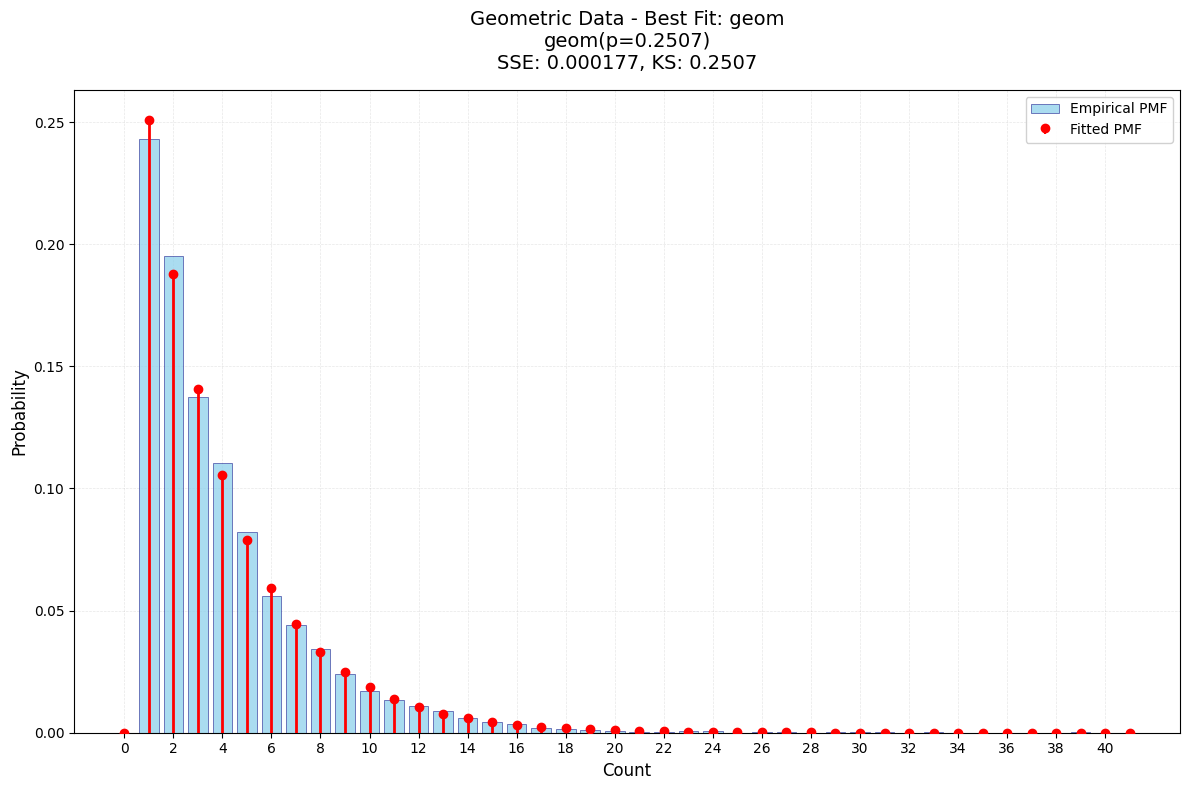

In [14]:
# Plot geometric fit
best_geom = results_geom.best(n=1, metric="aic")[0]

fig, ax = fitter.plot(
    best_geom,
    df_geom,
    "counts",
    title=f"Geometric Data - Best Fit: {best_geom.distribution}",
    xlabel="Count",
    ylabel="Probability",
    figsize=(12, 8),
)
plt.show()

---

# Part 6: Working with Results

In [15]:
# Convert results to pandas for analysis
df_results = results_poisson.df.toPandas()
print("Results as pandas DataFrame:")
df_results.sort_values("ks_statistic").head(10)

Results as pandas DataFrame:


,distribution,parameters,sse,aic,bic,ks_statistic,pvalue,ad_statistic,ad_pvalue
1,betabinom,"[26.0, 17.795874, 43.738834]",0.000111,48332.898438,48354.527344,0.142117,0.0,NaN,NaN
5,skellam,"[7.529535, 0.010532951]",0.000087,48320.210938,48334.632812,0.147564,0.0,NaN,NaN
3,poisson,[7.519],0.000087,48318.281250,48325.492188,0.147657,0.0,NaN,NaN
9,nbinom,"[565.35364, 0.98687494]",0.000098,48321.484375,48335.906250,0.148159,0.0,NaN,NaN
2,binom,"[26.0, 0.28919232]",0.002382,48999.640625,49014.062500,0.150689,0.0,NaN,NaN
7,planck,[0.12486579],0.068934,61625.300781,61632.511719,0.404779,0.0,NaN,NaN
6,dlaplace,[0.13260742],0.070748,74242.968750,74250.179688,0.665700,0.0,NaN,NaN
4,hypergeom,"[62.0, 31.0, 26.0]",0.186464,133214.984375,133236.609375,0.764508,0.0,NaN,NaN
0,boltzmann,"[1.0, 22.0]",0.554909,159557.500000,159571.921875,0.960184,0.0,NaN,NaN
8,nhypergeom,"[62.0, 31.0, 26.0]",0.106447,274209.406250,274231.031250,0.991386,0.0,NaN,NaN


In [16]:
# Filter by goodness-of-fit
good_fits = results_poisson.filter(ks_threshold=0.2)
print(f"Distributions with K-S statistic < 0.2: {good_fits.count()}")

for r in good_fits.best(n=10):
    print(f"  {r.distribution:15} KS={r.ks_statistic:.4f}")

Distributions with K-S statistic < 0.2: 5
  betabinom       KS=0.1421
  skellam         KS=0.1476
  poisson         KS=0.1477
  nbinom          KS=0.1482
  binom           KS=0.1507


## 6.1 Parameter Confidence Intervals

Compute bootstrap confidence intervals for discrete distribution parameters.

In [17]:
# Get parameter names for the best Poisson fit
print(f"Distribution: {best.distribution}")
print(f"Parameter names: {best.get_param_names()}")
print(f"Fitted values: {[f'{p:.4f}' for p in best.parameters]}")

# Compute 95% bootstrap confidence intervals
print("\nComputing 95% confidence intervals...")
ci = best.confidence_intervals(
    df_poisson,
    column="counts",
    alpha=0.05,           # 95% CI
    n_bootstrap=10000,    # Number of bootstrap samples
    random_seed=42,
)

print("\nParameter confidence intervals:")
for param, (lower, upper) in ci.items():
    print(f"  {param}: [{lower:.4f}, {upper:.4f}]")

# Compare to true parameter (λ = 7.5)
print(f"\nTrue λ = 7.5, fitted λ = {best.parameters[0]:.4f}")
print(f"95% CI contains true value: {ci['mu'][0] < 7.5 < ci['mu'][1]}")

Distribution: poisson
Parameter names: ['mu']
Fitted values: ['7.5190']

Computing 95% confidence intervals...



Parameter confidence intervals:
  mu: [7.4650, 7.5728]

True λ = 7.5, fitted λ = 7.5190
95% CI contains true value: True


---

## Summary

This notebook demonstrated:

1. **DiscreteDistributionFitter** - Main class for fitting discrete distributions
   - Same API as `DistributionFitter` for continuous data
   - Uses MLE optimization (discrete dists don't have built-in `fit()`)

2. **Available Distributions**:
   - poisson, nbinom, geom, binom, hypergeom, betabinom, zipf, and more
   - 16 discrete distributions by default

3. **Fitting**:
   - `fitter.fit(df, column)` - Fit all discrete distributions
   - Returns `FitResults` object (same as continuous)

4. **Model Selection** (recommended metrics):
   - **AIC** - Best for discrete model selection (lower is better)
   - **BIC** - Similar to AIC, stronger complexity penalty
   - K-S statistic works for ranking but p-values are not reliable for discrete data
   - **A-D statistic is not computed** for discrete distributions (it's designed for continuous CDFs)

5. **Results**:
   - `results.best(n, metric="aic")` - Get top N distributions by AIC
   - `results.filter(aic_threshold=...)` - Filter by information criteria
   - `result.get_param_names()` - Get parameter names for the distribution
   - `result.confidence_intervals()` - Bootstrap confidence intervals

6. **Plotting**:
   - `fitter.plot()` - Visualize fitted PMF vs empirical histogram
   - Shows stem plot for discrete probabilities

7. **Use Cases**:
   - **Poisson**: Event counts with constant rate
   - **Negative Binomial**: Overdispersed counts (variance > mean)
   - **Geometric**: Number of trials until first success
   - **Binomial**: Successes in n trials with probability p

In [18]:
spark.stop()
print("Spark session stopped.")

Spark session stopped.
